Adicionando o banco

In [2]:
import pandas as pd
import numpy as np

# Carregar o CSV
raw_path = "kendo_matches_work.csv"
df = pd.read_csv(raw_path)

print("Shape original:", df.shape)
display(df.head())

Shape original: (202, 9)


,Unnamed: 0,match_id,ippon_number,seconds_between,ippon_taken,men,kote,do,tsuki
0,1,1,1,1,0,1,0,0,0
1,2,1,2,5,1,0,1,0,0
2,3,2,1,10,0,0,1,0,0
3,4,2,2,48,0,1,0,0,0
4,5,3,1,38,0,1,0,0,0


In [3]:
# Remover coluna-índice exportada por engano
idx_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
if idx_cols:
    df = df.drop(columns=idx_cols)
    print(f"Removidas colunas de índice exportado: {idx_cols}")

Removidas colunas de índice exportado: ['Unnamed: 0']


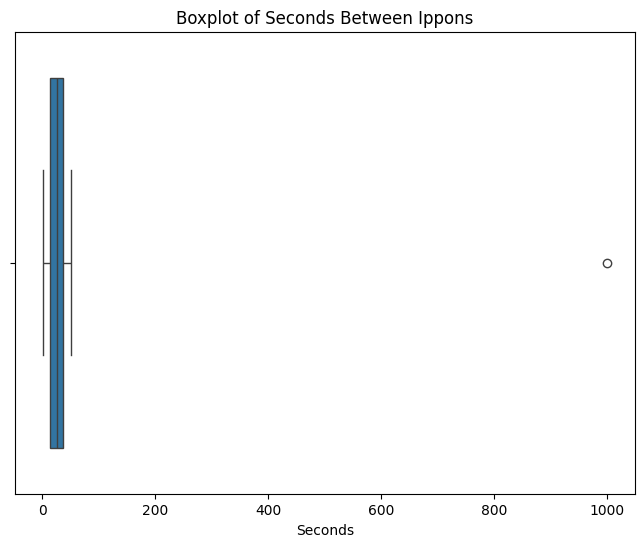

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot for the 'seconds_between' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['seconds_between'])
plt.title('Boxplot of Seconds Between Ippons')
plt.xlabel('Seconds')
plt.show()

In [5]:
# Padronização de tipos / mapeamento de valores
# Colunas esperadas
expected_cols = [
    "match_id", "ippon_number", "seconds_between", "ippon_taken",
    "men", "kote", "do", "tsuki"
]

# Verificar se todas existem (se faltar, acuse para evitar erro silencioso)
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Colunas ausentes no CSV: {missing}")

In [6]:
# Remover espaços em branco em strings
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip()

In [7]:
# Mapeamento de strings comuns para binário
# (O/o -> 0, I/l/| -> 1, yes/true/y -> 1, no/false/n -> 0)
binary_map = {
    "o": 0, "O": 0, "0": 0, "no": 0, "false": 0, "n": 0,
    "i": 1, "I": 1, "l": 0, "|": 1, "1": 1, "yes": 1, "true": 1, "y": 1
}


In [8]:
bin_cols = ["men", "kote", "do", "tsuki", "ippon_taken"]

for col in bin_cols:
    # aplica mapeamento em valores de texto conhecidos
    df[col] = df[col].replace(binary_map)
    # convert to Int64 after replacement, coercing errors to NaN
    df[col] = pd.to_numeric(df[col], errors="coerce").astype('Int64')

/tmp/ipython-input-728424066.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(binary_map)


In [9]:
# Convert all columns to numeric first, coercing errors to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now convert to Int64, which can handle NaNs
for col in df.columns:
    df[col] = df[col].astype('Int64')

In [10]:
# Validar campos binários (0/1)
# Qualquer valor que não seja 0 ou 1 nas colunas binárias será considerado erro -> NaN
for col in bin_cols:
    df.loc[~df[col].isin([0, 1]), col] = np.nan

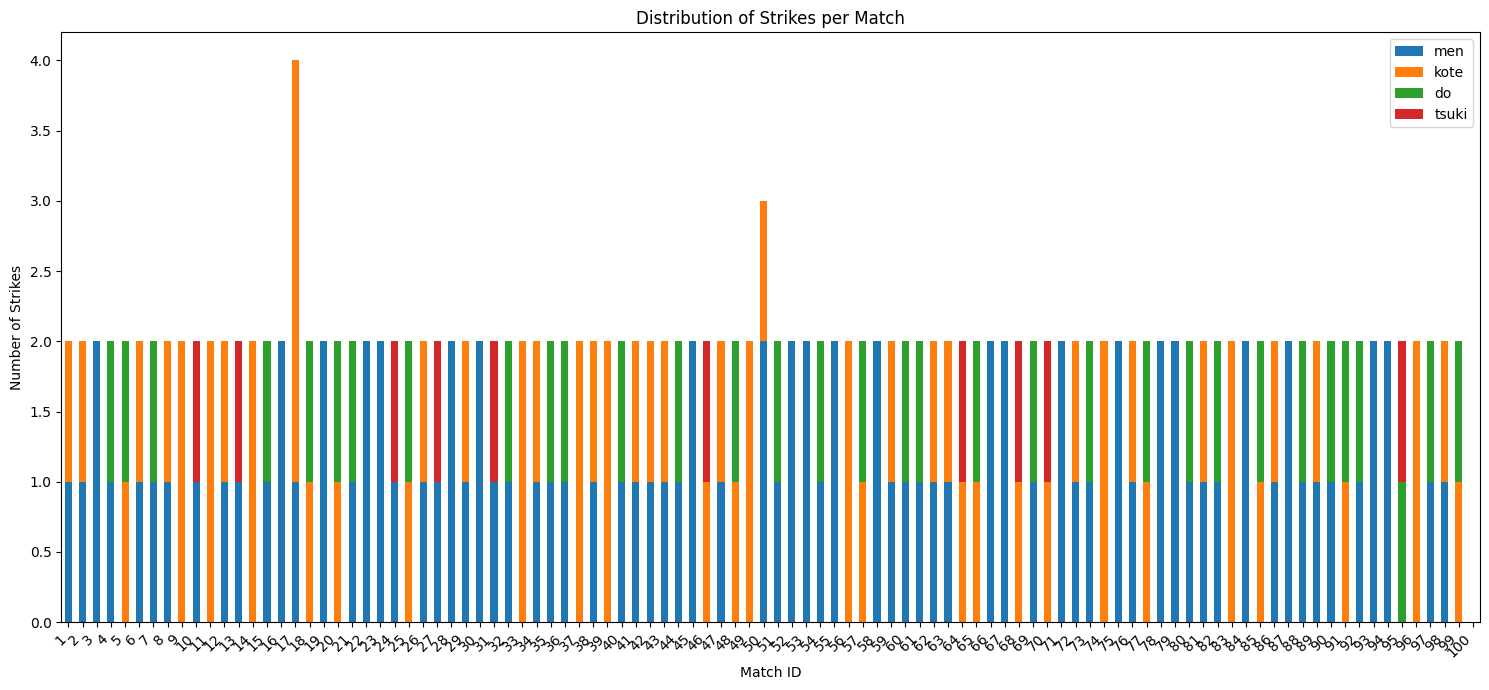

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by match_id and sum the strike counts
strike_summary = df.groupby('match_id')[['men', 'kote', 'do', 'tsuki']].sum()

# Create a stacked bar plot
strike_summary.plot(kind='bar', stacked=True, figsize=(15, 7))

plt.title('Distribution of Strikes per Match')
plt.xlabel('Match ID')
plt.ylabel('Number of Strikes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Dropar linhas que possuem seconds_between maiores que 300s (tempo de partida)
before_drop = df.shape[0]
df = df[df['seconds_between'] <= 300].copy()
after_drop = df.shape[0]

print(f"Número de linhas antes de remover: {before_drop}")
print(f"Número de linhas depois de remover: {after_drop}")

Número de linhas antes de remover: 202
Número de linhas depois de remover: 201


In [13]:
# Dropar linhas duplicadas
dup_before = df.shape[0]
df = df.drop_duplicates().copy()
dup_after = df.shape[0]

print(f"Número de linhas antes de dropar duplicadas: {dup_before}")
print(f"Número de linhas depois de dropar duplicadas: {dup_after}")

Número de linhas antes de dropar duplicadas: 201
Número de linhas depois de dropar duplicadas: 200


In [14]:
# Retirar partidas que não possuem valor verdadeiro nos golpes
# Criar uma máscara para identificar linhas onde a soma das colunas de golpe é 0 (ou NaN)
strike_cols = ["men", "kote", "do", "tsuki"]
# Check if the sum of strikes is 0 or NaN (assuming 1 for a valid strike)
mask_no_strike = (df[strike_cols].sum(axis=1) == 0) | (df[strike_cols].sum(axis=1).isna())

# Get the number of rows before dropping
before_drop = df.shape[0]

# Drop the rows where the mask is True
df = df[~mask_no_strike].copy()

# Get the number of rows after dropping
after_drop = df.shape[0]

print(f"Número de linhas antes de remover: {before_drop}")
print(f"Número de linhas depois de remover: {after_drop}")

display(df.head())

Número de linhas antes de remover: 200
Número de linhas depois de remover: 198


,match_id,ippon_number,seconds_between,ippon_taken,men,kote,do,tsuki
0,1,1,1,0,1,0,0,0
1,1,2,5,1,0,1,0,0
2,2,1,10,0,0,1,0,0
3,2,2,48,0,1,0,0,0
4,3,1,38,0,1,0,0,0


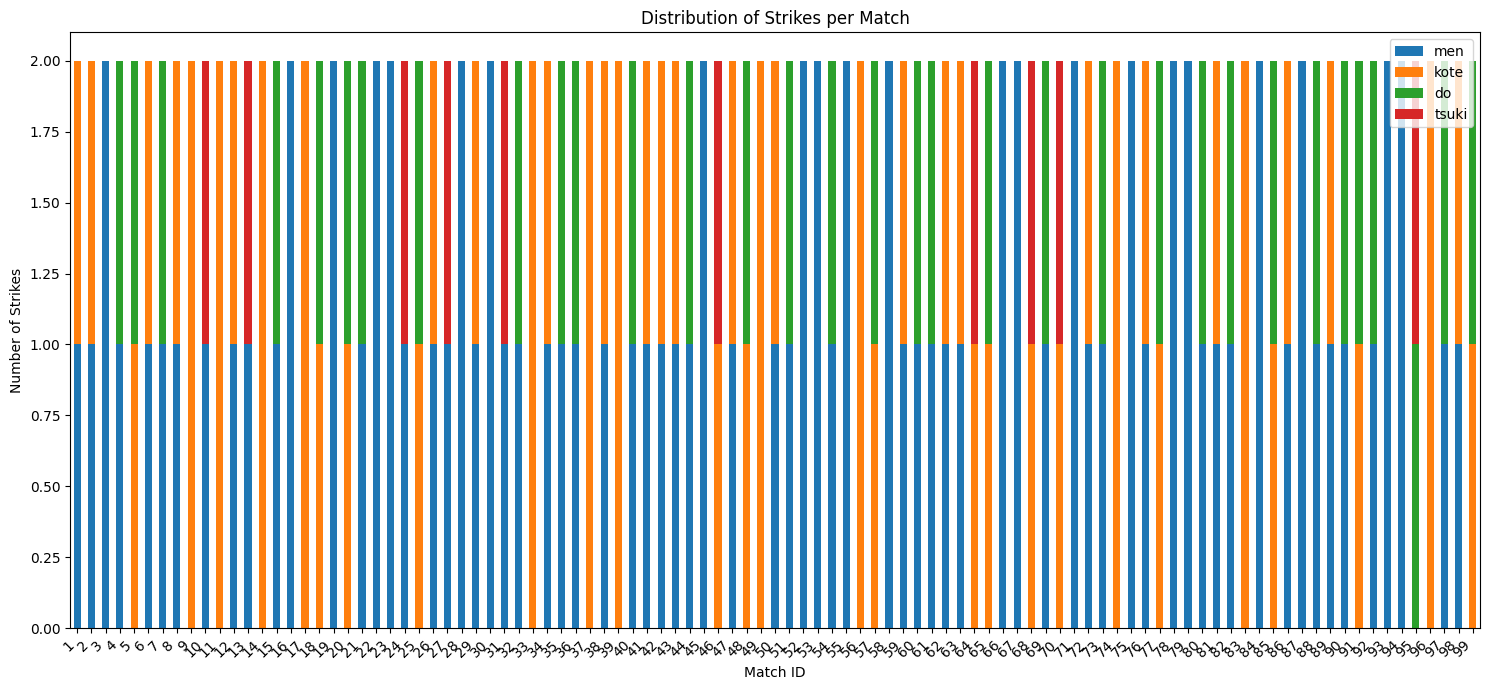

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by match_id and sum the strike counts
strike_summary = df.groupby('match_id')[['men', 'kote', 'do', 'tsuki']].sum()

# Create a stacked bar plot
strike_summary.plot(kind='bar', stacked=True, figsize=(15, 7))

plt.title('Distribution of Strikes per Match')
plt.xlabel('Match ID')
plt.ylabel('Number of Strikes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
transactions = []

for _, row in df.iterrows():
    items = []

    # golpes
    if row["men"] == 1: items.append("men")
    if row["kote"] == 1: items.append("kote")
    if row["do"] == 1: items.append("do")
    if row["tsuki"] == 1: items.append("tsuki")

    # se foi feito ou sofrido
    if row["ippon_taken"] == 0:
        items.append("feito")
    else:
        items.append("sofrido")

    # condições de tempo
    if row["seconds_between"] > 25:
        items.append("tempo>25")
    if row["seconds_between"] > 15:
        items.append("tempo>15")

    transactions.append(items)


In [18]:
!pip install mlxtend

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Transformar transações em one-hot encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_apriori = pd.DataFrame(te_ary, columns=te.columns_)

# Rodar Apriori
freq_items = apriori(df_apriori, min_support=0.05, use_colnames=True)

# Regras de associação
rules = association_rules(freq_items, metric="confidence", min_threshold=0.5)
rules.sort_values("confidence", ascending=False).head(10)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
51,"(kote, feito, tempo>25)",(tempo>15),0.080808,0.707071,0.080808,1.0,1.414286,1.0,0.023671,inf,0.318681,0.114286,1.0,0.557143
31,"(feito, tempo>25)",(tempo>15),0.308081,0.707071,0.308081,1.0,1.414286,1.0,0.090246,inf,0.423358,0.435714,1.0,0.717857
21,"(tempo>25, do)",(tempo>15),0.090909,0.707071,0.090909,1.0,1.414286,1.0,0.026630,inf,0.322222,0.128571,1.0,0.564286
15,(tempo>25),(tempo>15),0.510101,0.707071,0.510101,1.0,1.414286,1.0,0.149424,inf,0.597938,0.721429,1.0,0.860714
56,"(feito, tempo>25, men)",(tempo>15),0.146465,0.707071,0.146465,1.0,1.414286,1.0,0.042904,inf,0.343195,0.207143,1.0,0.603571
61,"(kote, tempo>25, sofrido)",(tempo>15),0.050505,0.707071,0.050505,1.0,1.414286,1.0,0.014794,inf,0.308511,0.071429,1.0,0.535714
65,"(tempo>25, men, sofrido)",(tempo>15),0.106061,0.707071,0.106061,1.0,1.414286,1.0,0.031068,inf,0.327684,0.150000,1.0,0.575000
37,"(kote, tempo>25)",(tempo>15),0.131313,0.707071,0.131313,1.0,1.414286,1.0,0.038465,inf,0.337209,0.185714,1.0,0.592857
47,"(feito, tempo>25, do)",(tempo>15),0.050505,0.707071,0.050505,1.0,1.414286,1.0,0.014794,inf,0.308511,0.071429,1.0,0.535714
46,"(tempo>25, sofrido)",(tempo>15),0.202020,0.707071,0.202020,1.0,1.414286,1.0,0.059178,inf,0.367089,0.285714,1.0,0.642857


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
rules[(rules['antecedents'] == {"men"}) & (rules['consequents'] == {"sofrido"})]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [20]:
rules[(rules['consequents'] == {"tempo>25"}) & (rules['confidence'] > 0.85)]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [21]:
rules[(rules['antecedents'] == {"tempo>15", "tempo>25"})]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
33,"(tempo>15, tempo>25)",(feito),0.510101,0.560606,0.308081,0.60396,1.077335,1.0,0.022115,1.10947,0.146527,0.403974,0.098668,0.576755


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
# Salvar CSV limpo
clean_path = "kendo_matches_TRATADOS.csv"
df.to_csv(clean_path, index=False)
print(f"\nArquivo salvo em: {clean_path}")


Arquivo salvo em: kendo_matches_TRATADOS.csv
